<a href="https://colab.research.google.com/github/Kjelloo/ML-Miniproject/blob/main/Cardiovascular_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)

### TODO
* ~Gather basic info about the data (empty or null values etc.)~
* Analyse data
    * ~Correlations~
    * Attribute combination (bmi?)
* Data prep
    * ~Clean data (remove outliers etc.)~
    * ~Split (70/30?)~
    * ~Feature scaling~
    * ~One hot encode (chol & glucose)~
* Fit, tune and test model
* Evaluation



## Features

    1. Age | Objective Feature | age | int (days) |
    2. Height | Objective Feature | height | int (cm) |
    3. Weight | Objective Feature | weight | float (kg) |
    4. Gender | Objective Feature | gender | categorical code |
    5. Systolic blood pressure | Examination Feature | ap_hi | int |
    6. Diastolic blood pressure | Examination Feature | ap_lo | int |
    7. Cholesterol | Examination Feature | cholesterol |
        1: normal, 2: above normal, 3: well above normal |
    8. Glucose | Examination Feature | gluc |
        1: normal, 2: above normal, 3: well above normal |
    9. Smoking | Subjective Feature | smoke | binary |
    10. Alcohol intake | Subjective Feature | alco | binary |
    11. Physical activity | Subjective Feature | active | binary |
    12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


## Imports & basic data info

In [70]:
import numpy as np
import pandas as pd
import zipfile
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from scipy.stats import uniform, randint
import joblib
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.simplefilter('ignore')

In [2]:
# copy kaggle api to kaggle folder
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [104]:
# download dataset
!kaggle datasets download -d sulianova/cardiovascular-disease-dataset
zip_ref = zipfile.ZipFile('/content/cardiovascular-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
data = pd.read_csv('/content/cardio_train.csv', sep=";")

cardiovascular-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [105]:
data.drop('id', axis=1, inplace=True)
data.drop_duplicates(inplace=True)

In [106]:
data.rename(columns={'cholesterol': 'chol'}, inplace=True)

In [107]:
data.head()

,age,gender,height,weight,ap_hi,ap_lo,chol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69976 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     69976 non-null  int64  
 1   gender  69976 non-null  int64  
 2   height  69976 non-null  int64  
 3   weight  69976 non-null  float64
 4   ap_hi   69976 non-null  int64  
 5   ap_lo   69976 non-null  int64  
 6   chol    69976 non-null  int64  
 7   gluc    69976 non-null  int64  
 8   smoke   69976 non-null  int64  
 9   alco    69976 non-null  int64  
 10  active  69976 non-null  int64  
 11  cardio  69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [ ]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,chol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


**The describe method tells us that youngest person in the dataset is about 30 (10798 days) old, while the smallest height-wise person is 55 cm, and one person weighs only 10 kg.
These are clearly errors that need removing during the data preparation. As well as ap_hi and ap_lo have negative values**

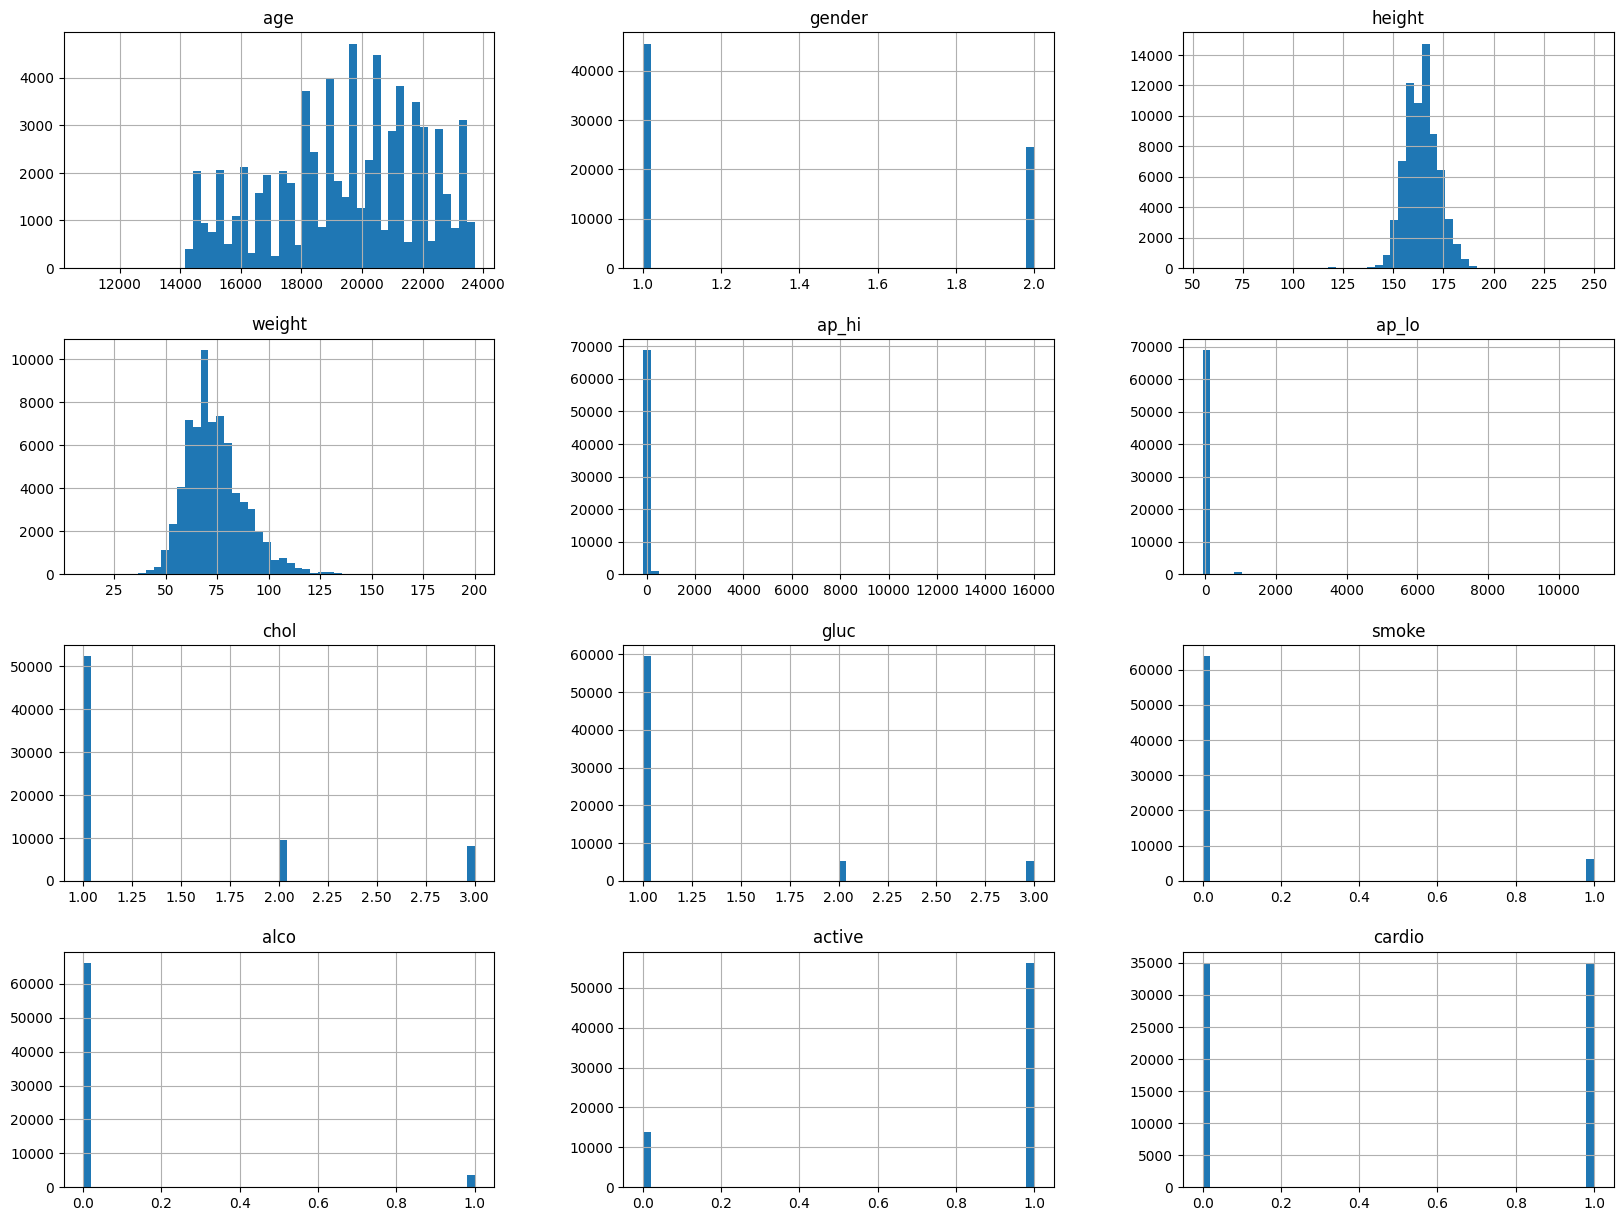

In [ ]:
data.hist(bins=50, figsize=(20,15))
plt.show()

In [108]:
data.isnull().values.any()

False

## Analyse data
Find correlations etc.

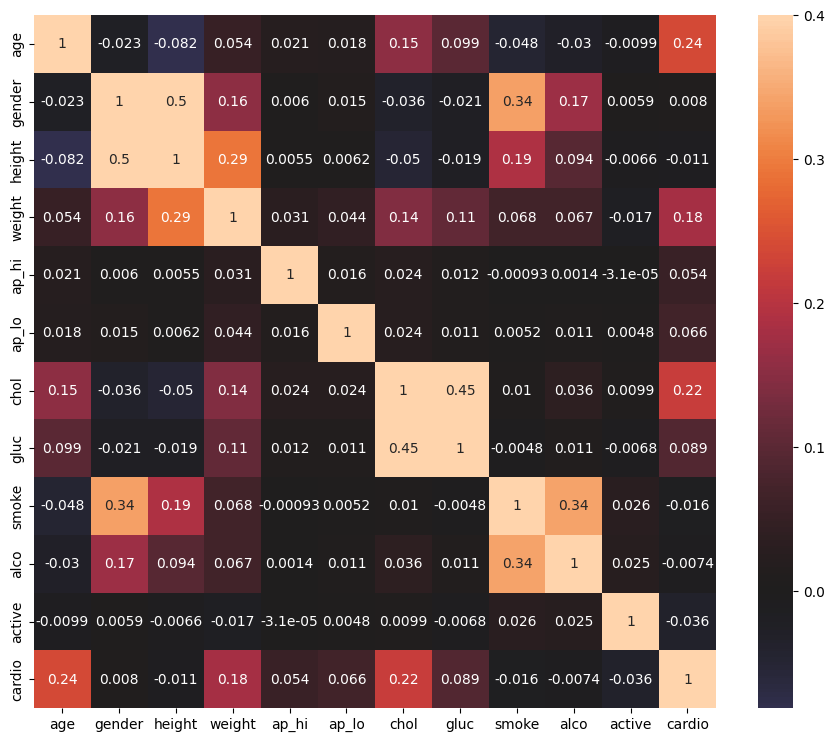

In [ ]:
corr = data.corr()
f, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(corr, vmax=.4, center=0,annot = True);

Correlations:

* Cardio: age, weight and age.
* Cholerstol: glucose
* Alcohol: smoke, gender (not really an important correlation)

There are probably some outliers that have an effect on this correlation matrix scewing some of the values.

## Prepare data


In [109]:
def remove_outliers(df):
    df = df[(df['weight'] >= 45) & (df['weight'] <= 200)]
    df = df[df['height'] >= 160]
    df = df[(df['ap_hi'] >= 20) & (df['ap_hi'] <= 250)]
    df = df[(df['ap_lo'] >= 20) & (df['ap_lo'] <= 150)]

    return df

data = remove_outliers(data)

In [110]:
data_target = data['cardio']
data = data.drop(['cardio'], axis=1)

I am combining the weight and height features into an BMI feature, since obese people are apt to developing heart diseases.

[Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10132081/)

In [111]:
data['bmi'] = data['weight'] / (data['height'] / 100) ** 2
data.drop(['weight', 'height'], axis=1, inplace=True)

In [112]:
train, test, target, target_test = train_test_split(data, data_target, test_size=0.2, random_state=0)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54989 entries, 48673 to 69523
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     54989 non-null  int64  
 1   gender  54989 non-null  int64  
 2   ap_hi   54989 non-null  int64  
 3   ap_lo   54989 non-null  int64  
 4   chol    54989 non-null  int64  
 5   gluc    54989 non-null  int64  
 6   smoke   54989 non-null  int64  
 7   alco    54989 non-null  int64  
 8   active  54989 non-null  int64  
 9   bmi     54989 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 4.6 MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13748 entries, 27089 to 15750
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     13748 non-null  int64  
 1   gender  13748 non-null  int64  
 2   ap_hi   13748 non-null  int64  
 3   ap_lo   13748 non-null  int64  
 4   chol    13748 non-null  int64  
 5   gluc    13748 non-null  int64  
 6   smoke   13748 non-null  int64  
 7   alco    13748 non-null  int64  
 8   active  13748 non-null  int64  
 9   bmi     13748 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 1.2 MB


In [114]:
onehot_params = ['gluc', 'chol', 'gender', 'smoke', 'active']
minmax_params = ['age', 'bmi', 'ap_hi', 'ap_lo']

# Create a ColumnTransformer
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), onehot_params),
    ('minmax', MinMaxScaler(), minmax_params)
])

## Train

In [122]:
gbc_reg = make_pipeline(
    preprocessor,
    GradientBoostingClassifier()
)

params_gbc = {
    'gradientboostingclassifier__n_estimators': [600, 700, 800],
    'gradientboostingclassifier__max_depth': [3, 5, 7, 10],
}

grid_search_gbc = GridSearchCV(gbc_reg, params_gbc, n_jobs=-1, cv=5)
grid_search_gbc.fit(train, target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['gluc',
                                                                          'chol',
                                                                          'gender',
                                                                          'smoke',
                                                                          'active']),
                                                                        ('minmax',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'ap_hi',
                                                                          'ap_lo'])])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': [3, 5, 7, 10],
                         'gradientboostingclassifier__n_estimators': [600, 700,
                                                                      800]})

In [123]:
joblib.dump(grid_search_gbc, "gbc_grid.pkl")

['gbc_grid.pkl']

In [115]:
hgb_reg = make_pipeline(
    preprocessor,
    HistGradientBoostingClassifier()
)

params = {
    'histgradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2, 0.4, 0.5],
    'histgradientboostingclassifier__max_iter': [20, 50, 80, 100],
    'histgradientboostingclassifier__min_samples_leaf': [2, 5, 10, 15, 20]
    }

grid_search_hbc = GridSearchCV(hgb_reg, params, n_jobs=-1, cv=5)

grid_search_hbc.fit(train, target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['gluc',
                                                                          'chol',
                                                                          'gender',
                                                                          'smoke',
                                                                          'active']),
                                                                        ('minmax',
                                                                         MinMaxScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'ap_hi',
                                                                          'ap_lo'])])),
                                       ('histgradientboostingclassifier',
                                        HistGradientBoostingClassifier(min_samples_leaf=10,
                                                                       random_state=0))]),
             n_jobs=-1,
             param_grid={'histgradientboostingclassifier__learning_rate': [0.01,
                                                                           0.1,
                                                                           0.2,
                                                                           0.4,
                                                                           0.5],
                         'histgradientboostingclassifier__max_iter': [20, 50,
                                                                      80, 100],
                         'histgradientboostingclassifier__min_samples_leaf': [2,
                                                                              5,
                                                                              10,
                                                                              15,
                                                                              20]})

In [78]:
joblib.dump(grid_search_hbc, "hgbc_grid.pkl")

['hgbc_grid.pkl']

In [124]:
grid_search_gbc.best_params_

{'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__n_estimators': 600}

In [117]:
grid_search_hbc.best_params_

{'histgradientboostingclassifier__learning_rate': 0.2,
 'histgradientboostingclassifier__max_iter': 50,
 'histgradientboostingclassifier__min_samples_leaf': 20}

### Evaluate train data

**Gradient boosting classifier**

In [125]:
gbc_train_pred = grid_search_gbc.predict(train)
acc_train_gbc = accuracy_score(gbc_train_pred, target)

acc_train_gbc

0.745795409576573

**Hist gradient boosting classifier**


In [118]:
hbc_train_pred = grid_search_hbc.predict(train)
acc_train_hbc = accuracy_score(hbc_train_pred, target)

acc_train_hbc

0.7436683814800158

### Evaluate test data

**Gradient boosting classifier**

In [126]:
gbc_test_pred = grid_search_gbc.predict(test)
acc_test_gbc = accuracy_score(gbc_test_pred, target_test)

acc_test_gbc

0.7365713720447127

**Hist gradient boosting classifier**

In [119]:
hbc_test_pred = grid_search_hbc.predict(test)
acc_test_hbc = accuracy_score(hbc_test_pred, target_test)

acc_test_hbc

0.7362746067860323